In [1]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastbook import *
from fastai.vision.widgets import *

#### Download Nsynth Dataset

In [4]:
!wget http://download.magenta.tensorflow.org/datasets/nsynth/nsynth-test.jsonwav.tar.gz

--2023-04-05 11:54:30--  http://download.magenta.tensorflow.org/datasets/nsynth/nsynth-test.jsonwav.tar.gz
Resolving download.magenta.tensorflow.org (download.magenta.tensorflow.org)... 142.250.141.128, 2607:f8b0:4023:c0d::80
Connecting to download.magenta.tensorflow.org (download.magenta.tensorflow.org)|142.250.141.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 349501546 (333M) [application/gzip]
Saving to: ‘nsynth-test.jsonwav.tar.gz’

nsynth-test.jsonwav 100%[===================>] 333.31M  84.1MB/s    in 4.0s    

2023-04-05 11:54:34 (84.1 MB/s) - ‘nsynth-test.jsonwav.tar.gz’ saved [349501546/349501546]



In [ ]:
!tar --gunzip --extract --verbose --file=nsynth-test.jsonwav.tar.gz

#### Converting Nsynth Dataset to Mel Spectrogram

In [3]:
from IPython.display import Audio
from tqdm import tqdm
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
from pathlib import Path
from multiprocessing import Pool
import os
import shutil
import pandas as pd
import librosa
from scipy.io import wavfile

In [4]:
def read_file(filename, path='', sample_rate=None, trim=False):
    ''' Reads in a wav file and returns it as an np.float32 array in the range [-1,1] '''
    filename = Path(path) / filename
    file_sr, data = wavfile.read(filename)
    if data.dtype == np.int16:
        data = np.float32(data) / np.iinfo(np.int16).max
    elif data.dtype != np.float32:
        raise OSError('Encounted unexpected dtype: {}'.format(data.dtype))
    if sample_rate is not None and sample_rate != file_sr:
        if len(data) > 0:
            data = librosa.core.resample(data, file_sr, sample_rate, res_type='kaiser_fast')
        file_sr = sample_rate
    if trim and len(data) > 1:
        data = librosa.effects.trim(data, top_db=40)[0]
    return data, file_sr


def transform_path(src_path, dst_path, transform_fn, fnames=None, processes=None, delete=False, **kwargs):
    src_path, dst_path = Path(src_path), Path(dst_path)
    if dst_path.exists() and delete:
        shutil.rmtree(dst_path)
    os.makedirs(dst_path, exist_ok=True)
    
    _transformer = partial(transform_fn, src_path=src_path, dst_path=dst_path, **kwargs)
    if fnames is None:
        fnames = [f.name for f in src_path.iterdir()]
    with Pool(processes=processes) as pool:
        with tqdm(total=len(fnames), unit='files') as pbar:
            for _ in pool.imap_unordered(_transformer, fnames):
                pbar.update()

In [5]:
def log_mel_spec_tfm(fname, src_path, dst_path):
    os.makedirs(dst_path, exist_ok = True)
    y, sr = librosa.load(str(src_path/fname), mono=True)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    img = librosa.display.specshow(D, y_axis='linear', x_axis='time',
                                  sr=sr)
    plt.savefig(str(dst_path/fname[:-4]) + '.png')
    plt.close()

In [6]:
DATA = Path('nsynth-test')
IMG_DATA = Path('Spectrogram')
# these folders must be in place
NSYNTH_AUDIO = DATA/'audio'

# these folders will be created
NSYNTH_IMAGES = IMG_DATA/'nsynth_images'
TRAIN_IMAGE_PATH = NSYNTH_IMAGES/'train'
VALID_IMAGE_PATH = NSYNTH_IMAGES/'valid'

In [7]:
nsynth_acoustic_fnames = [f.name for f in NSYNTH_AUDIO.iterdir()
                         if 'acoustic' in f.name]

In [8]:
fn = nsynth_acoustic_fnames[8]; fn

'reed_acoustic_018-062-050.wav'

In [9]:
Audio(str(NSYNTH_AUDIO/fn))

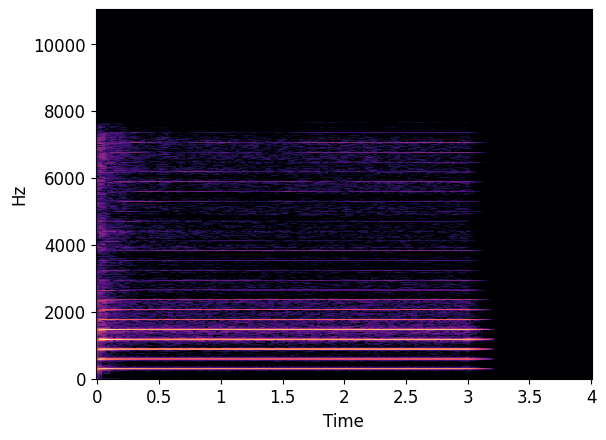

In [10]:
y, sr = librosa.load(str(NSYNTH_AUDIO/fn), mono=True)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
img = librosa.display.specshow(D, y_axis='linear', x_axis='time',
                              sr=sr)

In [11]:
for aud in tqdm(nsynth_acoustic_fnames[1002:]):
  log_mel_spec_tfm(aud, NSYNTH_AUDIO, IMG_DATA/(aud.split('_')[1] + '/' + aud.split('_')[0]))

100%|██████████| 687/687 [06:42<00:00,  1.71it/s]


#### Training The Classifier

In [12]:
path = Path('/content/Spectrogram/acoustic')

In [14]:
instruments = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [15]:
dls = instruments.dataloaders(path)

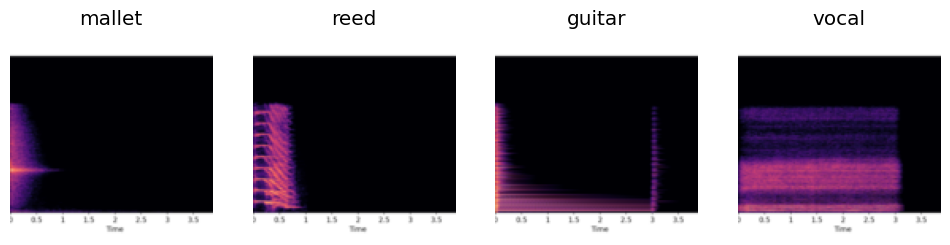

In [16]:
dls.valid.show_batch(max_n=4, nrows=1)

In [17]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.remove_cb(ProgressCallback)
learn.fine_tune(4)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 85.6MB/s]


[0, 2.2309460639953613, 1.1499130725860596, 0.34124627709388733, '02:27']
[0, 0.8142037987709045, 0.46892863512039185, 0.15727002918720245, '02:58']
[1, 0.6003009080886841, 0.24919655919075012, 0.0771513357758522, '03:03']
[2, 0.44896599650382996, 0.2560895085334778, 0.06824925541877747, '02:59']
[3, 0.3368159830570221, 0.2207743525505066, 0.05637982115149498, '03:00']


In [18]:
learn.fine_tune(5)

[0, 0.2025192379951477, 0.1809772551059723, 0.05044510215520859, '02:18']
[0, 0.1600448042154312, 0.11298105120658875, 0.020771512761712074, '02:57']
[1, 0.16306310892105103, 0.16183611750602722, 0.04747774451971054, '02:58']
[2, 0.1804511696100235, 0.16890127956867218, 0.03264094889163971, '02:56']
[3, 0.15507426857948303, 0.0906248465180397, 0.017804155126214027, '03:01']
[4, 0.1331464648246765, 0.08352791517972946, 0.017804155126214027, '02:56']


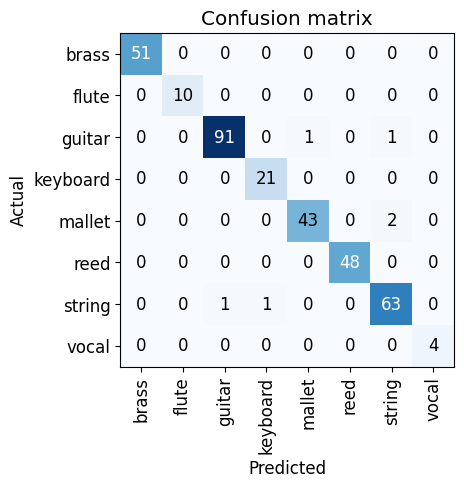

In [19]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [20]:
learn.export('model.pkl')